In [1]:
from PIL import Image
from matplotlib import pyplot as plt
from secrets import path_to_data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pdb

C:\Users\Excelsior\miniconda3\envs\pytorch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 64
beta = 4

In [3]:

class FfhqDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.image_paths[idx])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        return image
    

    def show_grid(self,nrows, ncols):
        n = nrows * ncols
        images = [self[i] for i in range(n)]
        fig, axes = plt.subplots(nrows, ncols)
        for i, ax in enumerate(axes.flat):
            if i < len(images):
                image = images[i]
                image = image.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
                #image = (image + 1) / 2  # Convert from [-1, 1] to [0, 1]
                ax.imshow(image)
                ax.axis('off')
        plt.show()

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))
])

path_to_trn = os.path.join(path_to_data,'training')
path_to_tst = os.path.join(path_to_data,'test')
dataset = FfhqDataset(root_dir=path_to_trn, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

tst_dataset = FfhqDataset(root_dir=path_to_tst, transform=transform)
tst_dataloader = DataLoader(tst_dataset, batch_size=32, shuffle=True)

In [4]:
dataset[0]

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0039,  ..., 0.0039, 0.0000, 0.0000],
         ...,
         [0.0941, 0.1020, 0.1137,  ..., 0.5490, 0.5412, 0.5294],
         [0.0902, 0.0902, 0.0980,  ..., 0.5294, 0.5176, 0.5137],
         [0.0667, 0.0745, 0.0863,  ..., 0.5216, 0.5216, 0.5255]],

        [[0.5098, 0.5020, 0.4902,  ..., 0.4706, 0.4588, 0.4510],
         [0.5059, 0.4941, 0.4980,  ..., 0.4392, 0.4392, 0.4431],
         [0.4824, 0.4902, 0.5098,  ..., 0.4706, 0.4314, 0.4196],
         ...,
         [0.6118, 0.6157, 0.6196,  ..., 0.6667, 0.6392, 0.6196],
         [0.6000, 0.6118, 0.6118,  ..., 0.6431, 0.6196, 0.6078],
         [0.5804, 0.5882, 0.5922,  ..., 0.6353, 0.6157, 0.6157]],

        [[0.5725, 0.5647, 0.5529,  ..., 0.6078, 0.6000, 0.5922],
         [0.5765, 0.5569, 0.5647,  ..., 0.5922, 0.5922, 0.5961],
         [0.5608, 0.5569, 0.5765,  ..., 0.6157, 0.5843, 0.

In [5]:
def display_tensor_as_image(image):
        image = image.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        #image = (image + 1) / 2  # Convert from [-1, 1] to [0, 1]
        image = (image * 255).byte()  # Convert from [0, 1] to [0, 255]
        pil_image = Image.fromarray(image.numpy())
        display(pil_image)
        return pil_image

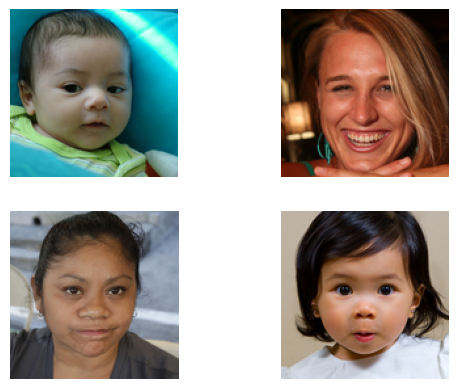

In [6]:
dataset.show_grid(2,2)

In [7]:
class ColorEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(ColorEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(128*32*32, 512)
        self.fc21 = nn.Linear(512, latent_dim)
        self.fc22 = nn.Linear(512, latent_dim)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = x.view(-1, 128*32*32)
        x = nn.functional.relu(self.fc1(x))
        mean = self.fc21(x)
        logvar = self.fc22(x)
        return mean, logvar



In [8]:
torch.Tensor.expand(dataset[0],1,3,128,128)

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0039, 0.0000, 0.0000],
          ...,
          [0.0941, 0.1020, 0.1137,  ..., 0.5490, 0.5412, 0.5294],
          [0.0902, 0.0902, 0.0980,  ..., 0.5294, 0.5176, 0.5137],
          [0.0667, 0.0745, 0.0863,  ..., 0.5216, 0.5216, 0.5255]],

         [[0.5098, 0.5020, 0.4902,  ..., 0.4706, 0.4588, 0.4510],
          [0.5059, 0.4941, 0.4980,  ..., 0.4392, 0.4392, 0.4431],
          [0.4824, 0.4902, 0.5098,  ..., 0.4706, 0.4314, 0.4196],
          ...,
          [0.6118, 0.6157, 0.6196,  ..., 0.6667, 0.6392, 0.6196],
          [0.6000, 0.6118, 0.6118,  ..., 0.6431, 0.6196, 0.6078],
          [0.5804, 0.5882, 0.5922,  ..., 0.6353, 0.6157, 0.6157]],

         [[0.5725, 0.5647, 0.5529,  ..., 0.6078, 0.6000, 0.5922],
          [0.5765, 0.5569, 0.5647,  ..., 0.5922, 0.5922, 0.5961],
          [0.5608, 0.5569, 0.5765,  ..., 0

In [9]:
class ColorDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(ColorDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 512)
        self.fc2 = nn.Linear(512, 128*32*32)
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, z):
        z = nn.functional.relu(self.fc1(z))
        z = nn.functional.relu(self.fc2(z))
        z = z.view(-1, 128, 32, 32)
        z = nn.functional.relu(self.conv1(z))
        z = nn.functional.relu(self.conv2(z))
        x = torch.sigmoid(self.conv3(z))
        return x



In [10]:
class ColorVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ColorVAE, self).__init__()
        self.encoder = ColorEncoder(latent_dim)
        self.decoder = ColorDecoder(latent_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = eps * std + mean
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu,logvar

def vae_loss(recon_x, x, mu, logvar, criterion,beta=beta):
    BCE = criterion(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

In [11]:
def show_example(model,idx=0,dataset=dataset):
    model.eval()
    example_batch = torch.Tensor.expand(dataset[idx],1,3,128,128).to(device)
    with torch.no_grad():
        example_output = model.forward(example_batch)
    ret = {
        'original':display_tensor_as_image(dataset[idx]),
        'recon':display_tensor_as_image(example_output[0][0].to('cpu'))
    }
    return ret

In [12]:
def generate_samples_from_vae(model,device='cuda',latent_dim=latent_dim,num_samples=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decoder(z).cpu()
    sample_images = [display_tensor_as_image(sample) for sample in samples]
    return sample_images

In [13]:
cvae = ColorVAE(latent_dim).to(device)

In [14]:
def eval_tst_vae_loss(model,criterion,dataloader=tst_dataloader):
    tst_loss = 0
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            batch_loss = vae_loss(recon_batch, data, mu, logvar, criterion)   
            tst_loss += batch_loss
    return tst_loss / len(tst_dataloader.dataset)

In [15]:
learning_rate=1e-3
num_epochs=300
num_epochs_completed = 0

optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')

In [ ]:
# time to train our VAE!

cvae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for data in dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data)
        loss = vae_loss(recon_batch, data, mu, logvar, criterion)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    test_loss = eval_tst_vae_loss(cvae,criterion)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(dataloader.dataset):.4f}, Test loss: {test_loss:.4f}")
    print("Trn Recon example:")
    show_example(cvae)
    print("Tst Recon example:")
    show_example(cvae, dataset=tst_dataset)
    print("Generated example:")
    generate_samples_from_vae(cvae,num_samples=1)
    cvae.train() # because the sample/example functions go into cvae.eval()
    num_epochs_completed += 1

In [ ]:
eval_tst_vae_loss(cvae,criterion)

In [ ]:
# save the model
test_loss = eval_tst_vae_loss(cvae,criterion)
savedir = f"latent_dim_{latent_dim}_tst_loss_{test_loss:.4f}_epochs_{num_epochs_completed}_beta_{beta}"
path_to_savedirs = os.path.join('.','saved_models','ColorVAE')
savedirpath = os.path.join(path_to_savedirs,savedir)
if savedir not in os.listdir(path_to_savedirs):
    os.mkdir(savedirpath)
savepath = os.path.join(savedirpath,"state_dict.pth")
torch.save(cvae.state_dict(), savepath)

# save some example images
num_examples_to_save = 2
print("Trn Recon example(s):")
trn_recon_examples = [show_example(cvae,idx = n,dataset=dataset) for n in range(num_examples_to_save)]
print("Tst Recon example(s):")
tst_recon_examples = [show_example(cvae,idx = n, dataset=tst_dataset) for n in range(num_examples_to_save)]
print("Generated example(s):")
generated_examples = generate_samples_from_vae(cvae,num_samples=num_examples_to_save)

reconpath = os.path.join(savedirpath,'recon')
if not 'recon' in os.listdir(savedirpath):
    os.mkdir(reconpath)
if not 'tst' in os.listdir(reconpath):
    os.mkdir(os.path.join(reconpath,'tst'))
    
if not 'trn' in os.listdir(reconpath):
    os.mkdir(os.path.join(reconpath,'trn'))
    
if not 'generated' in os.listdir(savedirpath):
    os.mkdir(os.path.join(savedirpath,'generated'))
for i in range(num_examples_to_save):
    trn_recon_examples[i]['original'].save(os.path.join(reconpath, 'trn', f"example_{i}_original.png"))
    trn_recon_examples[i]['recon'].save(os.path.join(reconpath, 'trn', f"example_{i}_recon.png"))
    tst_recon_examples[i]['original'].save(os.path.join(reconpath, 'tst', f"example_{i}_original.png"))
    tst_recon_examples[i]['recon'].save(os.path.join(reconpath, 'tst', f"example_{i}_recon.png"))
    generated_examples[i].save(os.path.join(savedirpath, 'generated', f"example_{i}.png"))

In [ ]:
generate_samples_from_vae(cvae,num_samples=100)